In [24]:
import csv
import numpy as np
import pandas as pd
from math import log, e
import copy
import pandas as pd
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plts

In [25]:
def readfile(trainfile):
    with open(trainfile) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        x=list(csv_reader)
        data=np.array(x).astype("int")
    return data

In [26]:
def readandpreprocess(input):
    data=readfile(input)
    m,n=np.shape(data)
    s=np.zeros(m)
    for i in range(1,n):
        if not len(set(data[:,i]))<=30:
            median=np.median(data[:,i])
            s=np.vstack((s,data[:,i]>median))
        elif len(set(data[:,i]))==2:
            n=list(set(data[:,i]))
            s=np.vstack((s,data[:,i]!=n[0]))
        else:
            s=np.vstack((s,data[:,i]))
    data=s.T[:,1:]
    return data

In [27]:
def entropy(labels, base=10):
    vc = pd.Series(labels).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

In [28]:
def infogain(labels,ydata):
    partition={part: np.where(labels == part)[0] for part in np.unique(labels)}
    listelements=list(set(labels))
    entropy_Y_Xa = sum((float(len(p)) / float(len(labels))) * entropy(ydata[p])
    for p in partition.values())
    return entropy(ydata)-entropy_Y_Xa


In [103]:
class node():
    def __init__(self,leafnode,label=None,parent=None,attribute=None,cval=None,spindex=None,children=[],median=None,Majority=None):
        self.leafnode=leafnode
        self.parent=parent
        self.attrib=attribute
        self.median=median
        self.maj=Majority
        if(not leafnode):
            self.spindex=spindex
            self.children=children
            self.cval=cval
        else:
            self.cval=cval
            self.label=label
    def __str__(self):
        if (self.leafnode):
            if hasattr(self,'label'):
                return "<Leaf node:label:"+str(self.label)+">"
            else:
                return "<Leaf node:label:"+str(self.maj)+">"
        else:
            if self.parent is not None:
                return "<internal node:will split on index:"+str(self.spindex)+",splitted on:"+str(self.attrib)+"parent is:"+str(self.parent)+">"
            else:
                return "<internal node:will split on index:"+str(self.spindex)+",splitted on:"+str(self.attrib)+">"
            

In [30]:
def best_attribute(data,usedindex=None):
    best_gain=-1
    index=-1
    if usedindex==None:
        for i in range(0,len(data[0,:])-1):
            temp_gain=infogain(data[:,i],data[:,-1])
            if temp_gain>best_gain:
                best_gain=temp_gain
                index=i
        return index,best_gain
    else:
        for i in range(0,len(data[0,:])-1):
            if i in usedindex:
                continue
            temp_gain=infogain(data[:,i],data[:,-1])
            if temp_gain>best_gain:
                best_gain=temp_gain
                index=i
        return index,best_gain

In [129]:
class decision_tree():
    def __init__(self, data):
        self.nodesatheight=[]
        self.root = self._createtrees(data,None,0)
    def bfs_tree(self):
        self.bfs=[]
        self.bfs.append(self.root)
        for node in self.bfs:
            if node.leafnode!=True:
                for child in node.children:
                    self.bfs.append(child)
    def _createtrees(self,data,parent,height):
        if data is None:
            return None
        #elif len(data[:,-1])<=15:
         #   maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
          #  return node(True,maxoccuringfreq,parent)
        else:
            if(len(set(data[:,-1]))==1):
                return node(True,data[0,-1],parent)
            else:
                if parent is None:
                    spindex,bgain=best_attribute(data)
                    if bgain>0: 
                        if(len(self.nodesatheight)<=height):
                            self.nodesatheight.append(0)
                        self.nodesatheight[height]+=1
                        partition={element: np.where(data[:,spindex] == element)[0] for element in np.unique(data[:,spindex])}.items()
                        majority=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        tempnode=node(False,None,None,[spindex],None,spindex,[],None,majority)
                        for key,part in partition:
                            print"----creating it's  child------"
                            
                            child=self._createtrees(data[part],tempnode,height+1)
                            if child is not None:
                                child.cval=key
                                tempnode.children.append(child)
                        return tempnode
                    else:
                        if(len(self.nodesatheight)<=height):
                            self.nodesatheight.append(0)
                        self.nodesatheight[height]+=1
                        maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        return node(True,maxoccuringfreq,parent) 
                else:
                    spindex,bgain=best_attribute(data,parent.attrib)
                    if bgain>0:
                        
                        if(len(self.nodesatheight)<=height):
                            self.nodesatheight.append(0)
                        self.nodesatheight[height]+=1
                        partition={element: np.where(data[:,spindex] == element)[0] for element in np.unique(data[:,spindex])}.items()
                        s=copy.deepcopy(parent.attrib)
                        s.append(spindex)
                        maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        tempnode=node(False,None,None,s,None,spindex,[],None,maxoccuringfreq)
                        for key,part in partition:
                            child=self._createtrees(data[part],tempnode,height+1)
                            if child is not None:
                                child.cval=key
                                tempnode.children.append(child)
                        return tempnode
                    else:
                        
                        if(len(self.nodesatheight)<=height):
                            self.nodesatheight.append(0)
                        self.nodesatheight[height]+=1
                        maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        return node(True,maxoccuringfreq,parent) 
        
                        

In [32]:
def predict(dtree,data,height=None):
    result=[]
    for row in data:
        if height is not None:
            temp=traversethroughtree(dtree.root,row,height,0)
        else:
            temp=traversethroughtree(dtree.root,row)
        result.append(temp)
    return result

In [97]:
def traversethroughtree(currnode,row,height=None,currheight=None):
    if currnode is None:
        return None
    
    if currnode.leafnode==True:
        if hasattr(currnode,'label'):
            return currnode.label
        else:
            return currnode.maj
    elif height==currheight and height is not None:
        return currnode.maj
    else :
        splitindex=currnode.spindex
        currval=row[splitindex]
        for nodes in currnode.children:
            if nodes.cval==currval:
                if height is not None:
                    return traversethroughtree(nodes,row,height,currheight+1)
                else:
                    return traversethroughtree(nodes,row)
                

In [34]:
def find_accuracies(data1,data2):
    correct=0
    num=0
    for a,b in zip(data1,data2):
        if a is not None:
            if a==b:
                correct+=1
        num+=1
    return float(correct)/num

In [35]:
#part c starts here, so here what we are writing

In [36]:
data=readfile('credit-cards.train.csv')

In [37]:
def preprocess(data):
    m,n=np.shape(data)
    s=np.zeros(m)
    for i in range(1,n):
        if len(set(data[:,i]))==2:
            n=list(set(data[:,i]))
            s=np.vstack((s,data[:,i]!=n[0]))
        else:
            s=np.vstack((s,data[:,i]))
    return np.array(s[1:,:]).astype('int').T

In [38]:
def preprocess2(data):
    data=data[:,1:].astype('int')
    m,n=np.shape(data)
    s=np.zeros(m)
    medians=[]
    for i in range(0,n):
        if i in [0,4,10,11,12,13,14,15,16,17,18,19,20,21,22]:
            median=np.median(data[:,i])
            s=np.vstack((s,data[:,i]>median))
            medians.append(median)
        else:
            s=np.vstack((s,data[:,i]))
            medians.append(-33)
    return np.array(s[1:,:]).astype('int').T,medians

In [39]:
class decision_tree_c():
    nodesatheight=[]
    def __init__(self, data):
        self.root = self._createtrees(data,None,0)
        
    def _createtrees(self,data,parent,height):
        if data is None:

            return None
        #elif len(data[:,-1])<=15:
         #   maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
          #  return node(True,maxoccuringfreq,parent)
        else:
            if(len(set(data[:,-1]))==1):
                return node(True,data[0,-1],parent)
            else:
                if parent is None:
                    if(len(self.nodesatheight)<=height):
                        self.nodesatheight.append(0)
                    self.nodesatheight[height]+=1
                    processdata,medians=preprocess2(data)
                    spindex,bgain=best_attribute(processdata)
                    if bgain>0:    
                        partition={element: np.where(processdata[:,spindex] == element)[0] for element in np.unique(processdata[:,spindex])}.items()
                        majority=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        tempnode=node(False,None,None,[spindex],None,spindex,[],medians[spindex],majority)
                        for key,part in partition:
                            print"----creating it's  child------"
                        
                            child=self._createtrees(data[part],tempnode,height+1)
                            if child is not None:
                                child.cval=key
                                tempnode.children.append(child)
                        return tempnode
                    else:
                        if(len(self.nodesatheight)<=height):
                            self.nodesatheight.append(0)
                        self.nodesatheight[height]+=1

                        if(len(self.nodesatheight)<=height):
                            self.nodesatheight.append(0)
                        self.nodesatheight[height]+=1
                        majority=maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        return node(True,maxoccuringfreq,parent) 
                else:
                    if(len(self.nodesatheight)<=height):
                        self.nodesatheight.append(0)
                    self.nodesatheight[height]+=1
                    processdata,medians=preprocess2(data)
                    spindex,bgain=best_attribute(processdata,parent.attrib)
                    if bgain>0:
                        partition={element: np.where(processdata[:,spindex] == element)[0] for element in np.unique(processdata[:,spindex])}.items()
                        s=copy.deepcopy(parent.attrib)
                        s.append(spindex)
                        majority=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        tempnode=node(False,None,None,s,None,spindex,[],medians[spindex],majority)
                        for key,part in partition:
                            child=self._createtrees(data[part],tempnode,height+1)
                            if child is not None:
                                child.cval=key
                                tempnode.children.append(child)
                        return tempnode
                    else:
                        majority=maxoccuringfreq=max(set(data[:,-1]), key = list(data[:,-1]).count) 
                        return node(True,maxoccuringfreq,parent) 
                        

In [40]:
def predictc(dtree,data,height=None):
    result=[]
    for row in data:
        if height is not None:
            temp=traversethroughtreec(dtree.root,row,height,0)
        else:
            temp=traversethroughtreec(dtree.root,row)
        result.append(temp)
    return result

In [41]:
def traversethroughtreec(currnode,row,height=None,currheight=None):
    if currnode is None:    
        return None
    elif currnode.leafnode==True:
        return currnode.label
        
    elif height==currheight and height is not None:
        return currnode.maj

    else :
        if(currnode.spindex not in [0,4,10,11,12,13,14,15,16,17,18,19,20,21,22]):
            splitindex=currnode.spindex
            currval=row[splitindex]
            for nodes in currnode.children:
                if nodes.cval==currval:
                    if height is not None:
                        return traversethroughtreec(nodes,row,height,currheight+1)
                    else:
                        return traversethroughtreec(nodes,row)
            return currnode.maj
        else:
            splitindex=currnode.spindex
            median=currnode.median
            if(row[splitindex]<=median):
                currval=0
            else:
                currval=1
            stat=False
            for nodes in currnode.children:
                if nodes.cval==currval:
                    if height is not None:
                        return traversethroughtreec(nodes,row,height,currheight+1)
                    else:
                        return traversethroughtreec(nodes,row)

In [42]:
def onehotencode(data):
    m,n=np.shape(data)
    s=np.zeros(m)
    for i in range(n):
        if i in [3,4,6,7,8,9,10,11]:
            s=np.vstack((s,onehotencodecol(data[:,i]).T))
        else:
            s=np.vstack((s,data[:,i]))
    return s[1:,:].astype('int').T

In [43]:
def onehotencodecol(a):
    if np.min(a)<0:
        a=a+abs(np.min(a))
    b = np.zeros((len(a), np.max(a)+1))
    b[np.arange(len(a)), a] = 1
    return b

In [44]:
data=readfile('credit-cards.train.csv')
data2=readfile('credit-cards.test.csv')
data3=readfile('credit-cards.val.csv')

In [45]:
#one hot encode

In [55]:
def parta():
    data=readandpreprocess('credit-cards.train.csv')
    root=decision_tree(data)
    datare=predict(root,data)
    print "the training accuracy is ",find_accuracies(datare,data[:,-1])
    data2=readandpreprocess('credit-cards.val.csv')
    datare=predict(root,data2)
    print "the cross-val accuracy is ",find_accuracies(datare,data2[:,-1])
    data3=readandpreprocess('credit-cards.test.csv')
    datare=predict(root,data3)
    print "the testing accuracy is ",find_accuracies(datare,data3[:,-1])
    acc=[]
    acc1=[]
    acc2=[]
    num=np.cumsum(root.nodesatheight)
    for i in range(len(root.nodesatheight)):
        acc.append(find_accuracies(predict(root,data,i),data[:,-1])*100)
        acc1.append(find_accuracies(predict(root,data2,i),data2[:,-1])*100)
        acc2.append(find_accuracies(predict(root,data3,i),data3[:,-1])*100)
    fig=plts.figure()
    plts.plot(num,acc,label='Train accuracy')
    plts.plot(num,acc1,label='Test accuracy')
    plts.plot(num,acc2,label='Validation accuracy')
    plts.xlabel('height of tree')
    plts.ylabel('accuracy')
    plts.ylim(60,100)
    plts.legend()
    fig.savefig('plot.png')
    plts.show()
    return root

----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
----creating it's  child------
the training accuracy is  0.947169601689
the cross-val accuracy is  0.729833333333
the testing accuracy is  0.731711381436


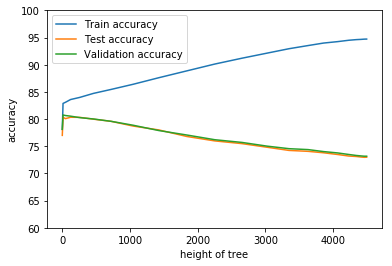

In [76]:
root=parta()

In [80]:
print(root.bfs[0])

<internal node:will split on index:5,splitted on:[5]>


In [49]:
def partc():
    data=readfile('credit-cards.train.csv')
    croot=decision_tree_c(data)
    datare=predictc(croot,data[:,1:])
    print "the training accuracy is ",find_accuracies(datare,data[:,-1])
    data2=readfile('credit-cards.val.csv')
    datare=predictc(croot,data2[:,1:])
    print "the cross-val accuracy is ",find_accuracies(datare,data2[:,-1])
    data3=readfile('credit-cards.test.csv')
    datare=predictc(croot,data3[:,1:])
    print "the testing accuracy is ",find_accuracies(datare,data3[:,-1])
    acc=[]
    acc1=[]
    acc2=[]
    num=np.cumsum(croot.nodesatheight)
    for i in range(len(croot.nodesatheight)):
        acc.append(find_accuracies(predictc(croot,data[:,1:],i),data[:,-1])*100)
        acc1.append(find_accuracies(predictc(croot,data2[:,1:],i),data2[:,-1])*100)
        acc2.append(find_accuracies(predictc(croot,data3[:,1:],i),data3[:,-1])*100)
    fig=plts.figure()
    plts.plot(num,acc,label='Train accuracy')
    plts.plot(num,acc1,label='Test accuracy')
    plts.plot(num,acc2,label='Validation accuracy')
    plts.xlabel('height of tree')
    plts.ylabel('accuracy')
    plts.ylim(60,100)
    plts.legend()
    fig.savefig('plot.png')
    plts.show()
    return crootNotebooks
    

In [ ]:
croot=partc()

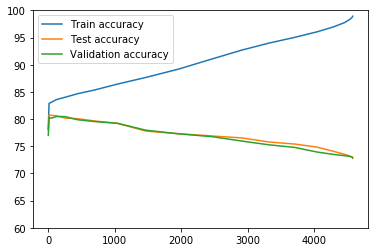

In [415]:
def partd():
    data=readfile('credit-cards.train.csv')
    model = tree.DecisionTreeClassifier()
    model.fit(data[:,1:-1],data[:,-1])
    datapred=model.predict(data[:,1:-1])
    print "the training accuracy is ",find_accuracies(datapred,data[:,-1])
    data=readfile('credit-cards.val.csv')
    datapred=model.predict(data[:,1:-1])
    print "the validation accuracy is ",find_accuracies(datapred,data[:,-1])
    data=readfile('credit-cards.test.csv')
    datapred=model.predict(data[:,1:-1])
    print "the testing accuracy is ",find_accuracies(datapred,data[:,-1])

In [416]:
partd()

the training accuracy is  0.999611111111
the validation accuracy is  0.717166666667
the testing accuracy is  0.728666666667


In [452]:
def parte():
    data=readfile('credit-cards.train.csv')
    data1=onehotencode(data)
    model = tree.DecisionTreeClassifier()
    model.fit(data1[:,1:-1],data1[:,-1])
    datapred=model.predict(data1[:,1:-1])
    print "the training accuracy is ",find_accuracies(datapred,data1[:,-1])
    data=readfile('credit-cards.val.csv')
    data1=onehotencode(data)
    datapred=model.predict(data1[:,1:-1])
    print "the validation accuracy is ",find_accuracies(datapred,data1[:,-1])
    data=readfile('credit-cards.test.csv')
    data1=onehotencode(data)
    datapred=model.predict(data1[:,1:-1])
    print "the testing accuracy is ",find_accuracies(datapred,data1[:,-1])

In [453]:
parte()

the training accuracy is  0.999611132715
the validation accuracy is  0.721
the testing accuracy is  0.723379436761


In [448]:
def partf():
    data=readfile('credit-cards.train.csv')
    clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
    clf.fit(data[:,1:-1], data[:,-1])
    datapred=clf.predict(data[:,1:-1])
    print "the training accuracy is ",find_accuracies(datapred,data[:,-1])
    data=readfile('credit-cards.val.csv')
    datapred=clf.predict(data[:,1:-1])
    print "the validation accuracy is ",find_accuracies(datapred,data[:,-1])
    data=readfile('credit-cards.test.csv')
    datapred=clf.predict(data[:,1:-1])
    print "the testing accuracy is ",find_accuracies(datapred,data[:,-1])

In [449]:
partf()

the training accuracy is  0.810121659908
the validation accuracy is  0.794166666667
the testing accuracy is  0.798033661056


In [60]:
bfs_trees=bfs_tree

In [113]:
datas=readandpreprocess('credit-cards.test.csv')

In [143]:
def prune(tree,data,label):
    length=[]
    accuracies=[]
    while True:
        tree.bfs_tree()
        bfs_trees=tree.bfs
        currnode=bfs_trees[0]
        cur=predict(tree,data)
        currac=find_accuracies(cur,label)
        accuracies.append(currac)
        lens=calculatenodes(tree.root)
        length.append(lens)
        masternode=currnode
        best_accuracy=0
        stat=0
        nodesa=0
        for nodes in bfs_trees:
            if not nodes.leafnode:
                nodes.leafnode=True
                pred=predict(tree,data)
                acc=find_accuracies(pred,label)
                if acc>best_accuracy:
                    stat+=1
                    masternode=nodes
                    best_accuracy=acc
                nodes.leafnode=False
        if stat>1:
            masternode.leafnode=True  
        print length,accuracies
    return lens,accuracies

In [144]:
prune(root,data[:,:-1],data[:,-1])

reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at le

reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at le

reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at le

reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at leaf node
reached at le

KeyboardInterrupt: 

In [135]:
def calculatenodes(tree):
    if tree.leafnode:
        return 1
    else:
        sume=0
        for nodes in tree.children:
            sume+=calculatenodes(nodes)
        sume+=1
        return sume

In [146]:
root.root.leafnode=False